In [1]:
import numpy as np
import cvxpy as cvx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import dpilqr as dec


In [2]:
COLLISION_RADIUS = 0.35
@partial(jax.jit, static_argnums=(0,))
@partial(jax.vmap, in_axes=(None, 0, 0))
def linearize(fd: callable,
              s: jnp.ndarray,
              u: jnp.ndarray):
    """Linearize the dynamics function `fd(s,u)` around nominal `(s,u)`."""

    # Use JAX to linearize `fd` around `(s,u)`.

    A = jax.jacfwd(fd,0)(s,u)
    B = jax.jacfwd(fd,1)(s,u)
    c = fd(s,u)-A@s-B@u

    return A, B, c

def solve_scp(fd: callable,
                      P: np.ndarray,
                      Q: np.ndarray,
                      R: np.ndarray,
                      N: int,
                      s_goal: np.ndarray,
                      s0: np.ndarray,
                      ρ: float,
                      tol: float,
                      max_iters: int,
                      n_drones: int):
    """This function is used for one-shot optimization"""
    n = Q.shape[0]  # state dimension
    m = R.shape[0]  # control dimension

    # Initialize nominal trajectories
    u_bar = np.zeros((N, m))
    s_bar = np.zeros((N + 1, n))
    s_bar[0] = s0
    for k in range(N):
        s_bar[k+1] = fd(s_bar[k], u_bar[k])

    # Do SCP until convergence or maximum number of iterations is reached
    converged = False
    obj_prev = np.inf
    iterate = 0
    s_prev = None
    for i in (prog_bar := tqdm(range(max_iters))):
        s, u, obj = scp_iteration(fd, P, Q, R, N, s_bar, u_bar, s_goal, s0,
                                 ρ, iterate, s_prev, n_drones)
        
        iterate+=1

        diff_obj = np.abs(obj - obj_prev)
        prog_bar.set_postfix({'objective change': '{:.5f}'.format(diff_obj)})

        if diff_obj < tol:
            converged = True
            print('SCP converged after {} iterations.'.format(i))
            break
        else:
            obj_prev = obj
            np.copyto(s_bar, s)
            np.copyto(u_bar, u)
            ρ = ρ * 0.85
        
        s_prev = s

    if not converged:
        raise RuntimeError('SCP di not converge!')

    return s, u


def scp_iteration(fd: callable, P: np.ndarray, Q: np.ndarray, R: np.ndarray,
                  N: int, s_bar: np.ndarray, u_bar: np.ndarray,
                  s_goal: np.ndarray, s0: np.ndarray,
                  ρ: float, iterate: int, s_prev: np.ndarray, n_drones: int):
    """Solve a single SCP sub-problem for the cart-pole swing-up problem."""
    A, B, c = linearize(fd, s_bar[:-1], u_bar)
    A, B, c = np.array(A), np.array(B), np.array(c)
    print(f'current iteration is {iterate}')
    n = Q.shape[0]
    m = R.shape[0]
    
    s_cvx = cvx.Variable((N + 1, n))
    u_cvx = cvx.Variable((N, m))

    objective = 0.

    constraints = []
    constraints +=[s_cvx[0,:] == s_bar[0]]

    for k in range(N):
        
        objective += cvx.quad_form(s_cvx[k,:] - s_goal, Q) + cvx.quad_form(u_cvx[k,:], R) 
        constraints += [s_cvx[k+1,:] == A[k]@s_cvx[k,:] + B[k]@u_cvx[k,:] + c[k]]

        #Adding constraints for each quadrotor:
        if n_drones > 1:

            for i in range(n_drones):
                """Convex trust region"""
                constraints += [cvx.pnorm(s_cvx[k,i*6:(i+1)*6]-s_bar[k,i*6:(i+1)*6],'inf') <= ρ]
                constraints += [cvx.pnorm(u_cvx[k,i*4:(i+1)*4]-u_bar[k,i*4:(i+1)*4],'inf') <= ρ] 
                
                constraints += [np.array([-1, -1, -1, 0]) <= u_cvx[k, i*4:(i+1)*4], \
                            u_cvx[k, i*4:(i+1)*4] <= np.array([1, 1, 1, 10])]
                
            
                #linearized collision avoidance constraints
                if iterate > 0:
                    prev_pos = [s_prev[k][id:id+6] for id in range(0, len(s_prev[k]), 6)]
                    curr_pos = [s_cvx[k][id:id+6] for id in range(0, len(s_prev[k]), 6)]
                    for j in range(n_drones):
                        if j != i:
                            constraints+= [cvx.norm(prev_pos[i][0:3]-prev_pos[j][0:3]) + \
                                        (prev_pos[i][0:3].T-prev_pos[j][0:3].T)/cvx.norm(prev_pos[i][0:3]-prev_pos[j][0:3])
                                            @ (curr_pos[i][0:3]-curr_pos[j][0:3]) >= COLLISION_RADIUS]
                            
        else: #in case we want to test our code with a single drone
   
            constraints += [np.array([ -1, -1, -1, 0]) <= u_cvx[k, :], \
                            u_cvx[k, :] <= np.array([1, 1, 1, 10])]
                

            constraints += [cvx.pnorm(s_cvx[k,:]-s_bar[k,:],'inf') <= ρ]
            constraints += [cvx.pnorm(u_cvx[k,:]-u_bar[k,:],'inf') <= ρ] 


    objective += cvx.quad_form(s_cvx[-1,:] - s_goal, P)
    print(f'total number of constraints is {len(constraints)}')
    prob = cvx.Problem(cvx.Minimize(objective), constraints)
    prob.solve(verbose = True)  
    
    if prob.status != 'optimal':
        raise RuntimeError('SCP solve failed. Problem status: ' + prob.status)

    s = s_cvx.value
    u = u_cvx.value

    obj = prob.objective.value

    return s, u, obj

In [3]:
def single_quad_dynamics(s, u, x_dims):
    #x_dims is just a place holder to make it consistent with multi_Quad_Dynamics

    tau_x, tau_y, tau_z, f_z = u[0], u[1], u[2], u[3]
    psi = s[3]
    theta = s[4]
    phi = s[5]
    v_x = s[6]
    v_y = s[7]
    v_z = s[8]
    w_x = s[9]
    w_y = s[10]
    w_z = s[11]

    #model is derived after plugging into physical parameters found via sys ID
    #see https://github.com/RandyChen233/AE483_Autonomous_Control_Lab/blob/main/lab05/analysis_part1.ipynb
    x_d = jnp.array([
        v_x*jnp.cos(psi)*jnp.cos(theta) + v_y*(jnp.sin(phi)*jnp.sin(theta)*jnp.cos(psi) - jnp.sin(psi)*jnp.cos(phi)) + v_z*(jnp.sin(phi)*jnp.sin(psi) + jnp.sin(theta)*jnp.cos(phi)*jnp.cos(psi)),
        v_x*jnp.sin(psi)*jnp.cos(theta) + v_y*(jnp.sin(phi)*jnp.sin(psi)*jnp.sin(theta) + jnp.cos(phi)*jnp.cos(psi)) - v_z*(jnp.sin(phi)*jnp.cos(psi) - jnp.sin(psi)*jnp.sin(theta)*jnp.cos(phi)), 
        -v_x*jnp.sin(theta) + v_y*jnp.sin(phi)*jnp.cos(theta) + v_z*jnp.cos(phi)*jnp.cos(theta), 
        (w_y*jnp.sin(phi) + w_z*jnp.cos(phi))/jnp.cos(theta), 
        w_y*jnp.cos(phi) - w_z*jnp.sin(phi), 
        w_x + w_y*jnp.sin(phi)*jnp.tan(theta) + w_z*jnp.cos(phi)*jnp.tan(theta), 
        v_y*w_z - v_z*w_y + 981.*jnp.sin(theta)/100., 
        -v_x*w_z + v_z*w_x - 981.*jnp.sin(phi)*jnp.cos(theta)/100., 
        2*f_z + v_x*w_y - v_y*w_x - 981.*jnp.cos(phi)*jnp.cos(theta)/100., 
        10000.*tau_x/23. - 17.*w_y*w_z/23., 
        10000.*tau_y/23. + 17.*w_x*w_z/23., 
        250.*tau_z
    ])
        
    return x_d

def multi_Quad_Dynamics(s, u, x_dims):
    """Constants such as the mass and half-body length, etc, are hard coded into the model below"""

    num_quadrotors = len(x_dims)

    g = 9.81
    n_states = 12
    n_inputs = 4
    # Split the state `s` and control input `u` into indiviual components
    xs = [s[i:i+n_states] for i in range(0, len(s), n_states)]
    us = [u[i:i+n_inputs] for i in range(0, len(u), n_inputs)]
    
    x_ds = []
    for i in range(num_quadrotors):
        
        tau_x, tau_y, tau_z, f_z = us[0], us[1], us[2], us[3]
        psi = xs[i][3]
        theta = xs[i][4]
        phi = xs[i][5]
        v_x = xs[i][6]
        v_y = xs[i][7]
        v_z = xs[i][8]
        w_x = xs[i][9]
        w_y = xs[i][10]
        w_z = xs[i][11]

        x_d = jnp.array([
        v_x*jnp.cos(psi)*jnp.cos(theta) + v_y*(jnp.sin(phi)*jnp.sin(theta)*jnp.cos(psi) - jnp.sin(psi)*jnp.cos(phi)) + v_z*(jnp.sin(phi)*jnp.sin(psi) + jnp.sin(theta)*jnp.cos(phi)*jnp.cos(psi)),
        v_x*jnp.sin(psi)*jnp.cos(theta) + v_y*(jnp.sin(phi)*jnp.sin(psi)*jnp.sin(theta) + jnp.cos(phi)*jnp.cos(psi)) - v_z*(jnp.sin(phi)*jnp.cos(psi) - jnp.sin(psi)*jnp.sin(theta)*jnp.cos(phi)), 
        -v_x*jnp.sin(theta) + v_y*jnp.sin(phi)*jnp.cos(theta) + v_z*jnp.cos(phi)*jnp.cos(theta), 
        (w_y*jnp.sin(phi) + w_z*jnp.cos(phi))/jnp.cos(theta), 
        w_y*jnp.cos(phi) - w_z*jnp.sin(phi), 
        w_x + w_y*jnp.sin(phi)*jnp.tan(theta) + w_z*jnp.cos(phi)*jnp.tan(theta), 
        v_y*w_z - v_z*w_y + 981.*jnp.sin(theta)/100., 
        -v_x*w_z + v_z*w_x - 981*jnp.sin(phi)*jnp.cos(theta)/100., 
        2*f_z + v_x*w_y - v_y*w_x - 981.*jnp.cos(phi)*jnp.cos(theta)/100., 
        10000.*tau_x/23. - 17.*w_y*w_z/23., 
        10000.*tau_y/23. + 17.*w_x*w_z/23., 
        250.*tau_z
        ])
        
        x_ds.append(x_d)

    return jnp.concatenate(x_ds)

def discretize(f, dt):
    """Discretize continuous-time dynamics `f` via Runge-Kutta integration."""

    def integrator(s, u, dt=dt):
        k1 = dt * f(s, u, x_dims)
        k2 = dt * f(s + k1 / 2, u, x_dims)
        k3 = dt * f(s + k2 / 2, u, x_dims)
        k4 = dt * f(s + k3, u, x_dims)
        return s + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return integrator


In [4]:
"""Run and example"""

n_drones = 1
n_states = 12
n_controls = 4
g = 9.81
n = n_drones * n_states                                # total state dimension
m = n_drones * n_controls                              # total control dimension

# s_goal = np.array([-1.5, -1.5, 1.2, 0,  0 , 0, 0, 0, 0, 0, 0 , 0, #drone 1
#                    1.5, 1.5, 1.2, 0, 0 , 0, 0, 0, 0, 0, 0, 0 #drone 2
#                    ])                                                     
# s0 = np.array([0.1, 0.2, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
#                -0.5, 0.3, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  

s_goal = np.array([-1.5, -1.5, 1.2, 0,  0 , 0, 0, 0, 0, 0, 0 , 0])  # for 1 drone only
s0 = np.array([0.1, 0.2, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


dt = 0.1                             # discrete time resolution
T = 10.                              # total simulation time

x_dims = [12, 12]
# fd = jax.jit(discretize(multi_Quad_Dynamics,dt))
fd = jax.jit(discretize(single_quad_dynamics,dt))

# SCP parameters

P = 1e3*np.eye(n)                    # terminal state cost matrix
Q = np.eye(n)*10  # state cost matrix
R = 1e-3*np.eye(m)                   # control cost matrix
ρ = 200                              # trust region parameter
tol = 5e-1                           # convergence tolerance
max_iters = 100                      # maximum number of SCP iterations

t = np.arange(0., T + dt, dt)
N = t.size - 1
# N = 50  

s, u = solve_scp(fd, P, Q, R, N, s_goal, s0, ρ, tol, max_iters, n_drones)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
  0%|          | 0/100 [00:00<?, ?it/s]

current iteration is 0
total number of constraints is 501
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Apr 08 10:31:08 AM: Your problem has 1612 variables, 501 constraints, and 0 parameters.
(CVXPY) Apr 08 10:31:08 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 08 10:31:08 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 08 10:31:08 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 08 10:31:08 AM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 08 10:31:08 AM: Reduct

  1%|          | 1/100 [00:05<09:42,  5.89s/it, objective change=inf]

current iteration is 1
total number of constraints is 501
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Apr 08 10:31:09 AM: Your problem has 1612 variables, 501 constraints, and 0 parameters.
(CVXPY) Apr 08 10:31:09 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 08 10:31:09 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 08 10:31:09 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 08 10:31:09 AM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 08 10:31:09 AM: Reduct

  2%|▏         | 2/100 [00:06<04:57,  3.04s/it, objective change=84121477.10006]

current iteration is 2
total number of constraints is 501
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Apr 08 10:31:10 AM: Your problem has 1612 variables, 501 constraints, and 0 parameters.
(CVXPY) Apr 08 10:31:10 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 08 10:31:10 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 08 10:31:10 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 08 10:31:10 AM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 08 10:31:10 AM: Reduct

  3%|▎         | 3/100 [00:07<03:17,  2.04s/it, objective change=15054104.77923]

current iteration is 3
total number of constraints is 501
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Apr 08 10:31:11 AM: Your problem has 1612 variables, 501 constraints, and 0 parameters.
(CVXPY) Apr 08 10:31:11 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 08 10:31:11 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 08 10:31:11 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 08 10:31:11 AM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 08 10:31:11 AM: Reduct

  4%|▍         | 4/100 [00:08<02:31,  1.58s/it, objective change=5.33201]       

current iteration is 4
total number of constraints is 501
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Apr 08 10:31:12 AM: Your problem has 1612 variables, 501 constraints, and 0 parameters.
(CVXPY) Apr 08 10:31:12 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 08 10:31:12 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 08 10:31:12 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 08 10:31:12 AM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 08 10:31:12 AM: Reduct

  5%|▌         | 5/100 [00:09<02:04,  1.31s/it, objective change=1.23494]

current iteration is 5
total number of constraints is 501
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Apr 08 10:31:13 AM: Your problem has 1612 variables, 501 constraints, and 0 parameters.
(CVXPY) Apr 08 10:31:13 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 08 10:31:13 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 08 10:31:13 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 08 10:31:13 AM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 08 10:31:13 AM: Reduct

  5%|▌         | 5/100 [00:10<03:15,  2.06s/it, objective change=0.39542]

SCP converged after 5 iterations.


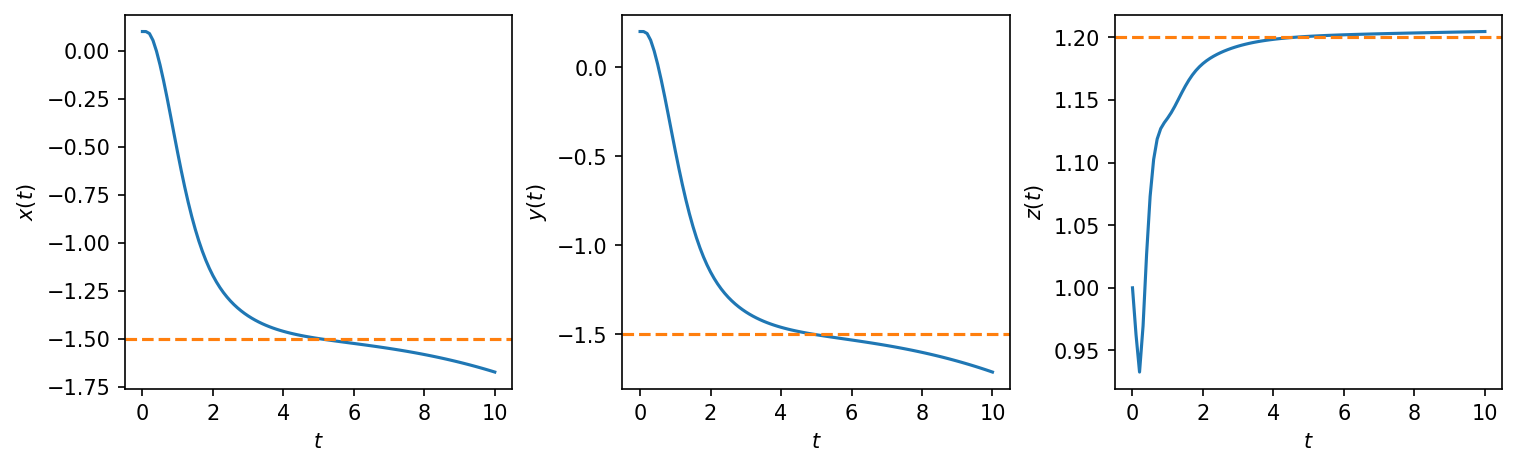

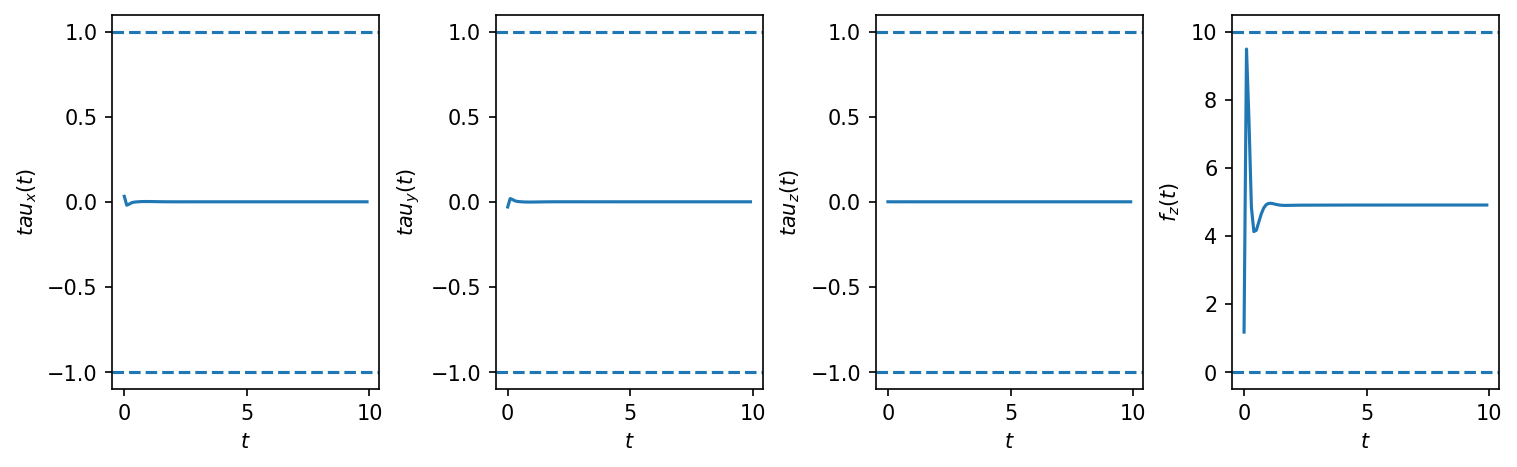

In [5]:
# Simulate open-loop control
for k in range(N):
    s[k+1] = fd(s[k], u[k])

# Plot state trajectories
fig, ax = plt.subplots(1, 3, figsize=(10, 3), dpi=150)
ylabels = (r'$x(t)$', r'$y(t)$', r'$z(t)$', r'$tau_x(t)$',r'$tau_y(t)$',r'$tau_z(t)$',r'$f_z(t)$')

for i in range(3):
    ax[i].plot(t, s[:, i], color='tab:blue')
    ax[i].axhline(s_goal[i], linestyle='--', color='tab:orange',label='reference position')
    ax[i].set_xlabel(r'$t$')
    ax[i].set_ylabel(ylabels[i])

plt.savefig('state_tracking(singleDrone).png',
            bbox_inches='tight')
plt.show()

#Plot control trajectories
fig, ax = plt.subplots(1, 4, figsize=(10, 3), dpi=150)
u_ref_upper = np.array([1, 1, 1, 10])
u_ref_lower = np.array([-1, -1, -1, 0])

for j in range(4):

    ax[j].plot(t[:-1], u[:, j])
    ax[j].axhline(u_ref_upper[j], linestyle='--',label='upper input bound')
    ax[j].axhline(u_ref_lower[j], linestyle='--',label='lower input input')
    ax[j].set_xlabel(r'$t$')
    ax[j].set_ylabel(ylabels[j+3])


plt.savefig('control_tracking(singleDrone).png',
            bbox_inches='tight')
plt.show()

In [6]:
import numpy as np

In [7]:
u_try = np.array([0, 0, 0, 4.9])

In [8]:
u_bar = np.tile(u_try ,(N,1))

In [9]:
u_bar.shape

(100, 4)

In [22]:
"""Run SCP in receding horizon"""

count = 0
si = s0
obj_list = []
n_agents = 1
N = 10
n_states = 12
u_try = np.array([0, 0, 0, 4.9])
u_bar = np.tile(u_try ,(N,1))
s_bar = np.zeros((N + 1, n))
s_bar[0] = s0
for k in range(N):
    s_bar[k+1] = fd(s_bar[k], u_bar[k])

X_trj =  np.zeros((0, n))  #Full trajectory over entire problem horizon (not just a single prediction horizon)
STEP_SIZE=1

iterate = 0
s_prev = None
obj_prev = np.inf

tol = 5e-1
while not np.all(dec.distance_to_goal(si, s_goal.reshape(1,-1), n_agents ,n_states,n_d= 3) < 0.1) :
    s, u, obj = scp_iteration(fd, P, Q, R, N, s_bar, u_bar, s_goal, si,  ρ, iterate, s_prev, n_drones)

    s_prev = s
    
    diff_obj = np.abs(obj - obj_prev)
    print(f'current diff_obj is {diff_obj}')
    if diff_obj < tol:
            
        print('SCP converged')
        break
    
    else:
        obj_prev = obj
        #Re-initialize nominal trajectory to shift prediction horizon
        s_bar = np.zeros((N + 1, n))
        s_bar[0] = s[STEP_SIZE]
        u_bar = np.tile(u_try ,(N,1))
        u_bar[0] = u[STEP_SIZE-1]

        count +=1
        
        obj_list.append(obj)
        
        print(f'current objective value is {obj}!\n')

        X_trj = np.r_[X_trj, s[:STEP_SIZE]]
        print(f'X_trj has shape {X_trj.shape}\n')

        if count >=60:
            print('max iteration reached')
            break


current iteration is 0
total number of constraints is 51
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Apr 08 10:50:43 AM: Your problem has 172 variables, 51 constraints, and 0 parameters.
(CVXPY) Apr 08 10:50:43 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 08 10:50:43 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 08 10:50:43 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 08 10:50:43 AM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 08 10:50:43 AM: Reduction

In [23]:
X_trj.shape

(21, 12)

Full trajectory has shape (21, 12)


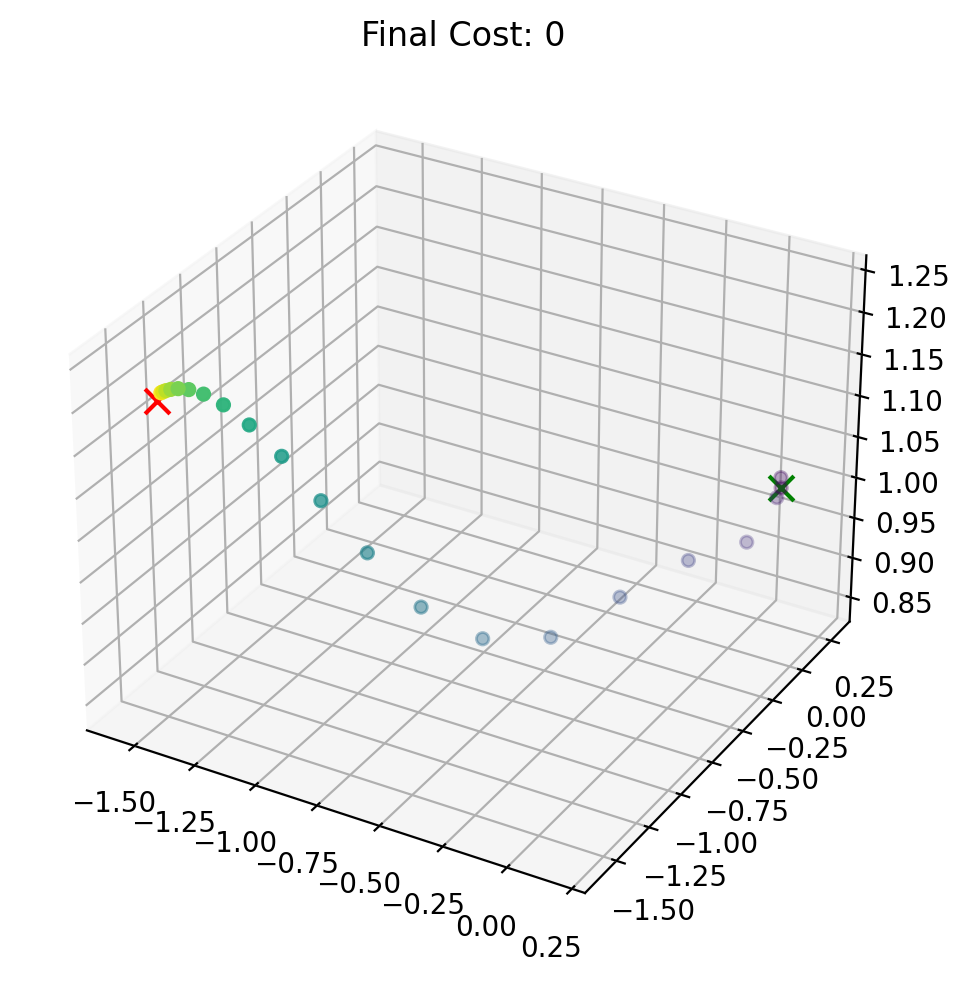

In [24]:
# Plot state and control trajectories
print(f'Full trajectory has shape {X_trj.shape}')
fig = plt.figure(dpi=200)
dec.plot_solve(X_trj,0,s_goal,x_dims = [12],n_d = 3)
plt.savefig('1quad_rhc_SCP.png')